# Simple Dogs and Cats Classifier

This notebook demonstrates a simple classifier to distinguish between images of cats versus dogs. A function maps input images to a 128D feature space, which then gets mapped to a 2D space so it can be plotted easily. 

From there, centroids can be calculated for the simple classifier, which is run on the user supplied test data. The images that are determined to be dogs are shown, and then the same for cats.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import glob

from sklearn.decomposition import PCA

import sys
sys.path.append("./src")
from model import FeatureModel

Using TensorFlow backend.


In [2]:
# object to load model, and get features from it
feature_object = FeatureModel.from_h5("final_model.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Train/Test Data

In [3]:
# test/train files
files_test = glob.glob("user_data/*")
files_train = glob.glob("training_data/cats/*") + glob.glob("training_data/dogs/*")

# training labels
train_labels = np.zeros(600)
train_labels[300:] = 1

## Extracting Features

In [4]:
def produce_features(list_of_files):
    """simple status bar loader for features"""
    features = []
    for fname in tqdm.tqdm(list_of_files):
        features.append(feature_object.image_to_features(fname).flatten())
    features = np.array(features)
    return features

In [5]:
# get features from the FeatureModel
features_train = produce_features(files_train)
features_test = produce_features(files_test)

100%|██████████| 24/24 [00:03<00:00,  7.25it/s]


In [6]:
# the incoming features are too highly dimensional to view on 2D plot
# reduce to a 2D feature space using PCA
pca = PCA(n_components=2)
pca.fit(features_train)
features_train_r = pca.transform(features_train)
features_test_r = pca.transform(features_test)

In [7]:
kernel_matrix = np.dot(features_test, features_test.T)

## Plotting the Feature Space

In [8]:
# calculate centroids for simple classification algorithm
centroid_cats = features_train_r[train_labels==0, :].mean(axis=0)
centroid_dogs = features_train_r[train_labels==1, :].mean(axis=0)

[0.10427601 0.99454844]


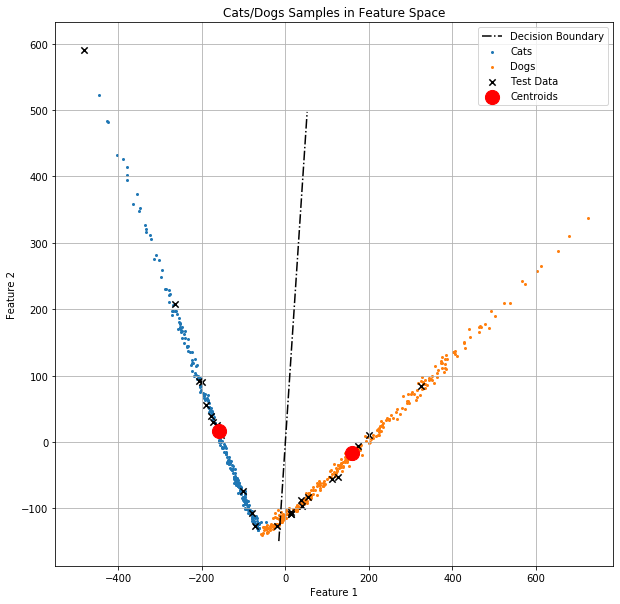

In [9]:
## 2D Feature Plot
fig, ax = plt.subplots(figsize=(10, 10))

# plot training data
ax.scatter(*features_train_r[train_labels==0, :].T, s=4, label="Cats")
ax.scatter(*features_train_r[train_labels==1, :].T, s=4, label="Dogs")

# plot test data
ax.scatter(*features_test_r.T, c='k', marker='x', s=40, label="Test Data")

# plot centroids
ax.scatter(*np.vstack((centroid_cats, centroid_dogs)).T, s=200, c='r', label="Centroids")

# draw decision line
# TODO: this code is inefficient 
b = (np.vstack((centroid_cats, centroid_dogs)).mean(axis=0))
m = np.array([(- centroid_dogs[1] + centroid_cats[1]), (centroid_dogs[0] - centroid_cats[0])])
m /= np.linalg.norm(m)
print(m)
ts = np.linspace(-150, 500, 100)
pts = []
for t in ts:
    pt = m * t + b
    pts.append(pt)
pts = np.array(pts)
ax.plot(pts[:, 0], pts[:, 1], '-.k', label="Decision Boundary")

ax.legend()
ax.set_title("Cats/Dogs Samples in Feature Space")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.grid()

## Kernelized Approach

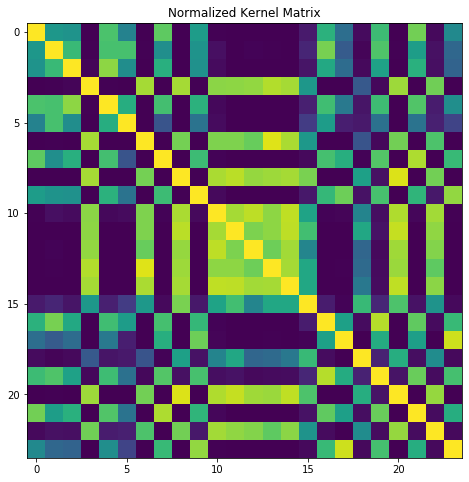

In [10]:
# normalized kernel matrix
D = np.diag(1 / np.sqrt(np.diag(kernel_matrix)))
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(D @ kernel_matrix @ D)
plt.title("Normalized Kernel Matrix")
plt.show()

In [11]:
# kernel version training

## KERNELS
linear_kernel = lambda x, xi: np.dot(x, xi)
kernel_func = lambda x, xi: linear_kernel(x, xi)


# data sets -- map to -1, 1 like the textbook
X,Y = features_train_r, train_labels
Y[Y==0] = -1
xp = X[Y == 1, :]
xn = X[Y == -1, :]

# lengths for positive and negative training data
mp = np.shape(xp)[0]
mn = np.shape(xn)[0]

# combute b
b = 0
total_calcs = np.shape(xp)[0]**2 + np.shape(xn)[0]**2
for xi in xp:
    for xj in xp:
        b -= 1/(mp**2)*kernel_func(xi, xj)
for xi in xn:
    for xj in xn:
        b += 1/(mn**2)*kernel_func(xi, xj)
b *= 0.5
b = b

## Classifying the User Supplied Data

In [12]:
def classify_feats(features_reduced):
    """geometric interpretation implementation--assign based on closest centroid"""
    decisions = []
    for fv in features_reduced:
        dists = np.linalg.norm(centroid_cats - fv), np.linalg.norm(centroid_dogs - fv)
        decisions.append(np.argmin(dists))
    return np.array(decisions)


def classify_feats_kernel(features_reduced):
    """kernel version"""
    decisions = []
    for x in features_reduced:
        g = b
        for xi in xp:
            g += 1/mp * kernel_func(x, xi)
        for xi in xn:
            g -= 1/mn * kernel_func(x, xi)
        decisions.append(int(np.sign(g) * 0.5 + 0.5))
    return np.array(decisions)

In [13]:
from PIL import Image
def plot_test_data(c, files_test):
    """plot images on matplotlib axes"""
    names = ["Cats", "Dogs"]
    test_classes = classify_feats_kernel(features_test_r)
    test_filenames = list(np.array(files_test)[np.where(test_classes==c)])
    n_imgs = len(test_filenames)
    n_cols = int(np.floor(np.sqrt(n_imgs)))
    n_rows = int(np.ceil(np.sqrt(n_imgs)))
    fig, ax = plt.subplots(figsize=(3*n_cols, 3*n_rows), ncols=n_cols, nrows=n_rows)
    for idx, fname in enumerate(test_filenames):
        xidx = idx % n_cols
        yidx = idx // n_cols
        ax[yidx][xidx].imshow(Image.open(fname))
        ax[yidx][xidx].get_xaxis().set_visible(False)
        ax[yidx][xidx].get_yaxis().set_visible(False)
    ax[0][0].set_title(f"Images Classified as {names[c]}")
    plt.tight_layout()

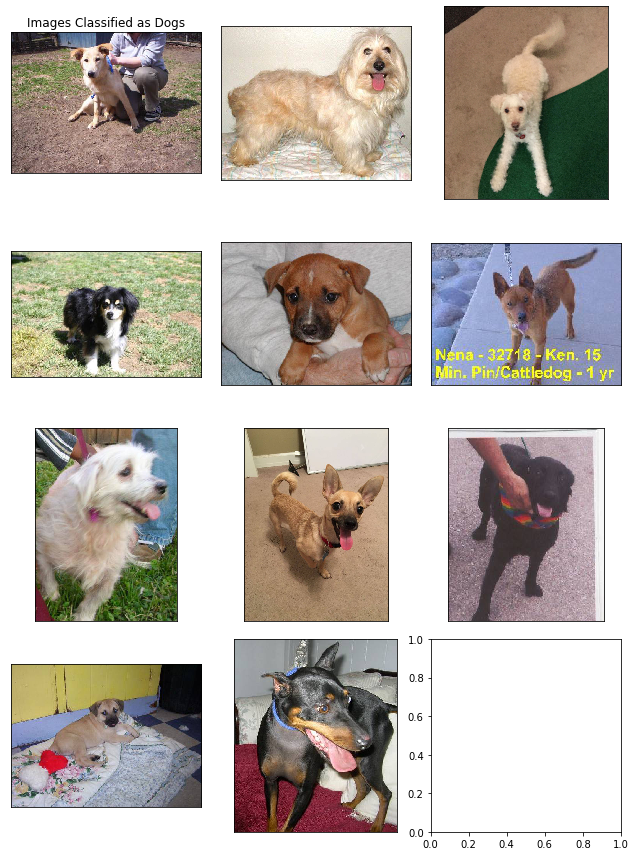

In [14]:
# plot images classified as label 1 -- dogs
plot_test_data(1, files_test)

IndexError: index 4 is out of bounds for axis 0 with size 4

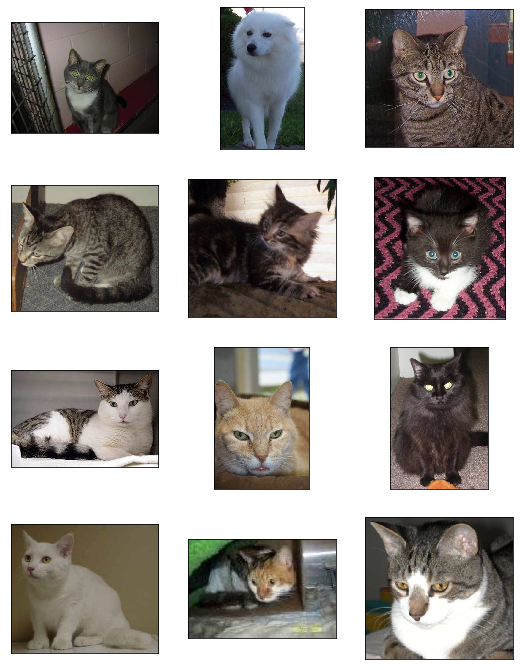

In [15]:
# plot images classified as label 0 -- cats
plot_test_data(0, files_test)